## Imports

In [1]:
import math
import rasterio
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import cv2 as cv2
import gdal

## Read and visualize

In [2]:
raster = gdal.Open("INSAT3D_TIR1_India\\3DIMG_07NOV2019_0000_L1C_SGP.tif")

type(raster)

osgeo.gdal.Dataset

In [3]:
from osgeo import gdal
file = gdal.Open( 'INSAT3D_TIR1_India\\3DIMG_07NOV2019_0000_L1C_SGP.tif')

def pixel(dx,dy):
    px = file.GetGeoTransform()[0]
    py = file.GetGeoTransform()[3]
    rx = file.GetGeoTransform()[1]
    ry = file.GetGeoTransform()[5]
    x = dx/rx + px
    y = dy/ry + py
    return x,y

## Lat-long extremities

In [104]:
ds = gdal.Open("INSAT3D_TIR1_India\\3DIMG_07NOV2019_0000_L1C_SGP.tif") 
xoffset, px_w, rot1, yoffset, px_h, rot2 = ds.GetGeoTransform()

Map shape=  (984, 1074)
Min pixel value =  530.0 Max pixel value =  948.0


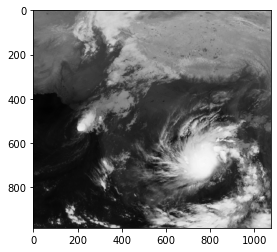

In [76]:
def IR(fname):
    sat_data = rasterio.open("INSAT3D_TIR1_India"+"\\"+fname) 
    b = sat_data.read(1)
    print("Map shape= ",b.shape)
    print("Min pixel value = ",b.min(),"Max pixel value = ",b.max())
    fig = plt.imshow(b,cmap="gray")
    return b,sat_data
b,sat_data=IR("3DIMG_07NOV2019_0000_L1C_SGP.tif")


## Calculate dimensions on earth

In [6]:
width_in_projected_units = sat_data.bounds.right - sat_data.bounds.left
height_in_projected_units = sat_data.bounds.top - sat_data.bounds.bottom

print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))

Width: 36.013661782652136, Height: 32.995757163994135


## Print rows and columns

In [7]:
print("Rows: {}, Columns: {}".format(sat_data.height, sat_data.width))

Rows: 984, Columns: 1074


## Coordinate Transform (Depends on co-ordinate reference system)

In [8]:
# Upper left pixel
row_min = 0
col_min = 0
from affine import Affine


# Lower right pixel.  Rows and columns are zero indexing.
row_max = sat_data.height - 1
col_max = sat_data.width - 1
    # Function to convert pixel row/column index (from 0) to easting/northing at centre


    # Project all longitudes, latitudes

topleft = sat_data.transform * (row_min, col_min)
botright = sat_data.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (62.9883746791066, 38.02897834557538)
Bottom right corner coordinates: (95.9505995695601, 2.0488488364638897)


This tells us the image coordinates range from 62.98 to 95.95 degrees in longitude and 2 to 38.02 degrees in latitude

## Bands(channels) in image. 1 band in this case means only one wavelength(infrared was used)

In [9]:
print(sat_data.count)

# sequence of band indexes
print(sat_data.indexes)

1
(1,)


## Function to visualize

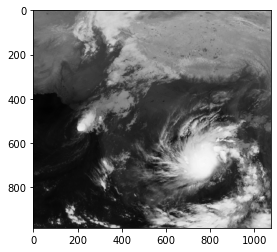

In [10]:
def visualize(b):
    b = sat_data.read(1)
    fig = plt.imshow(b,cmap="gray")
visualize(b)

## Code to convert all images to grayscale and save

Note : IMAGES IN GRAYSCALE ARE ONLY FOR VISUALIZATION PURPOSES AND NOT TO BE USED FOR INFERRING PROPERTIES.
NOR IS THE GRAYSCALE AN ACCURATE REPRESENTATION OF THE VALUES OF THE ORIGINAL IMAGES

### Infrared images

In [51]:
def irconv(dname):
    mn=1023
    mx=0
    i=0
    for filename in os.listdir(dname):
        i+=1
        sat_data = rasterio.open(dname+"\\"+filename) 
        b = sat_data.read(1)
        if(b.min()<mn):
            mn=b.min()
        if(b.max()>mx):
            mx=b.max()
      #  b=np.interp(b, (b.min(),b.max()), (0, 255))
        b=np.interp(b, (b.min(),b.max()), (0, 255))

     #   b=np.round(b)
        b=b.astype(np.uint8)
        l=len(filename)
        cv2.imwrite("IRimgs\\"+filename[0:l-3]+"png",b)
    print(mn,mx)
irconv("INSAT3D_TIR1_India")

387.0 975.0


### Visible Light

In [14]:
def vsconv(dname):
    mn=1023
    mx=0
    for filename in os.listdir(dname):
        sat_data = rasterio.open(dname+"\\"+filename) 
        b = sat_data.read(1)
        if(b.min()<mn):
            mn=b.min()
        if(b.max()>mx):
            mx=b.max()
        b=np.interp(b, (0,1023), (0,255))
        b=np.round(b)
        l=len(filename)
        cv2.imwrite("Visss\\"+filename[0:l-3]+"png",b)
    print(mn,mx)
vsconv("INSAT3D_VIS_India")

4.0 577.0


### Lat-long conversions With affine transform

In [15]:
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform

def coordinates():
    fname = "INSAT3D_TIR1_India\\3DIMG_07NOV2019_0000_L1C_SGP.tif"

    # Read raster
    with rasterio.open(fname) as r:
        T0 = r.transform  # upper-left pixel corner affine transform
        p1 = Proj(r.crs)
        A = r.read()  # pixel values

    # All rows and columns
    cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)
    # Function to convert pixel row/column index (from 0) to easting/northing at centre
    rc2en = lambda r, c: (c, r) * T1

    # All eastings and northings (there is probably a faster way to do this)
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

    # Project all longitudes, latitudes
    p2 = Proj(proj='latlong',datum='WGS84')
    lats,longs = transform(p1, p2, eastings, northings)
    return lats,longs
(lats,longs)=coordinates()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Right multiplication will be prohibited in version 3.0


In [17]:
print(longs.min(),longs.max())
print(lats.min(),lats.max())

63.00514081587692 98.98527032498842
5.049987318351569 38.01221220880506


## Various cloud attributes

### To get more insights into INSAT-3D products we downloaded the entire tiff file with all 6 channels 

In [105]:
import h5py
filename = "D:\\ISRO SIH\\tir1.h5"

with h5py.File(filename, "r") as f:
    print("Keys: %s" % f.keys())
    rad = list(f['IMG_TIR1_RADIANCE'])
    TIR = list(f['IMG_TIR1'])[0]
    BR=list(f['IMG_TIR1_TEMP'])
    vis=list(f['IMG_VIS'])[0]
    val=list(f['IMG_VIS_ALBEDO'])
    vrad=list(f['IMG_VIS_RADIANCE'])

Keys: <KeysViewHDF5 ['GreyCount', 'IMG_MIR', 'IMG_MIR_RADIANCE', 'IMG_MIR_TEMP', 'IMG_SWIR', 'IMG_SWIR_RADIANCE', 'IMG_TIR1', 'IMG_TIR1_RADIANCE', 'IMG_TIR1_TEMP', 'IMG_TIR2', 'IMG_TIR2_RADIANCE', 'IMG_TIR2_TEMP', 'IMG_VIS', 'IMG_VIS_ALBEDO', 'IMG_VIS_RADIANCE', 'IMG_WV', 'IMG_WV_RADIANCE', 'IMG_WV_TEMP', 'Projection_Information', 'Sat_Azimuth', 'Sat_Elevation', 'Sun_Azimuth', 'Sun_Elevation', 'X', 'Y', 'proj_dim', 'time']>


In [106]:
df=pd.DataFrame()
df['albedo']=val
df['Pixel_Val']=np.arange(1024)
df['RADIANCE']=vrad

In [107]:
df.to_excel('VIS.xlsx')

## Save mappings for visible readings 

In [108]:
v1=[]
for i in vis[472:1456]:
    v1.append(i[1161:2235])

In [109]:
vrad=np.array(vrad)
vrad*=10


In [110]:
vrad.max()

524.0

### Plot of visible albedo vs. visible radiance

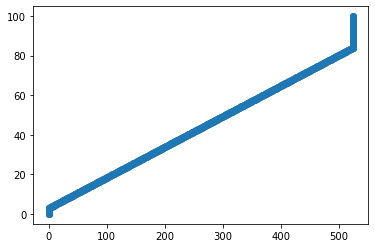

In [111]:
import matplotlib.pyplot as plt


plt.scatter(vrad, val)
plt.show()

In [112]:
v1=np.array(v1)


In [113]:
b2=np.zeros((984,1074))

In [114]:
for i in range(984):
    for j in range(1074):
        x=val[int(v1[i][j])]
        if(x>10):
            b2[i][j]=255

In [116]:
b2=b2.astype(np.int)

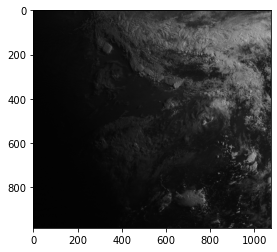

In [117]:
fig=plt.imshow(v1,cmap="gray")

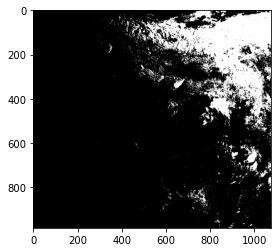

In [118]:
fig=plt.imshow(b2,cmap='gray')

# Cloud detection

### Establish threshold from previous 30 days images

Ref : Retrieval and Validation of Cloud Top Temperature from the Geostationary Satellite INSAT-3D Chaluparambil B. Lima 1, Sudhakaran S. Prijith 1, Mullapudi V. R. Sesha Sai 1, Pamaraju V. N. Rao 1, Kandula Niranjan 2 and Muvva V. Ramana 1,*

We consider highest temperature over the previous 30 days as surface temperature. We then compare that with the present temperature to determine if the pixel is cloudy or not


In [38]:
dname="D:\\Downloads\\SEQ"
bmax=[]
bj=[0]*1074
for j in range(984):
    bmax.append(bj)

for filename in os.listdir(dname):
        sat_data = rasterio.open(dname+"\\"+filename) 
        b = sat_data.read(1)
        b1=b[472:1456,1161:2235]
#        b3=np.array(b1)
        b1=np.array(b1)
        b1=b1.astype(np.int)
#        b3=np.interp(b3, (0,1023), (0, 255))
#        b3=np.round(b3)
#        b3=b3.astype(np.uint8)
#        l=len(filename)
#        cv2.imwrite("D:\\Downloads\\SEQ1\\"+filename[0:l-3]+"png",b3)
        for i in range(len(b1)):
            for j in range(len(b1[0])):
                b1[i][j]=BR[b1[i][j]//1]
                if(bmax[i][j]<b1[i][j]):
                    bmax[i][j]=b1[i][j]

In [31]:
bmax=np.array(bmax)
bmax.shape

(984, 1074)

### save threshold values

In [60]:
np.save("max values",bmax)

In [61]:
bmax=np.load('max values.npy')

In [62]:
bmax.max()

335

In [81]:
sat_data= rasterio.open('INSAT3D_TIR1_India\\3DIMG_07NOV2019_1200_L1C_SGP.tif') 
b = sat_data.read(1)

In [82]:
b=b.astype(np.int)
b[0]

array([628, 628, 628, ..., 777, 780, 783])

## Original Image

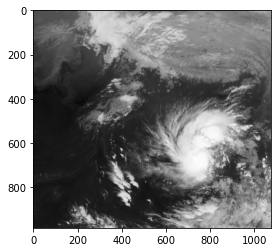

In [85]:
fig=plt.imshow(b,cmap='gray')

### Convert TIR readings Temperature

In [86]:
for i in range(len(b)):
    for j in range(len(b[0])):
        b[i][j]=BR[b[i][j]//1]

In [87]:
b2=np.zeros((984,1074))

In [88]:
print(bmax[0][0],b[0][0])

305 279


## Overall cloudy

In [89]:
for i in range(len(b)):
    for j in range(len(b[0])):
        if(b[i][j]<0.93*bmax[i][j]):
            b2[i][j]=255

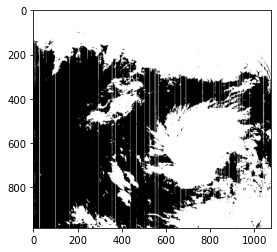

In [90]:
fig=plt.imshow(b2,cmap='gray')

In [ ]:
b2=np.zeros((984,1074))

## Low clouds

In [91]:
for i in range(len(b)):
    for j in range(len(b[0])):
        if(b[i][j]<270):
            b2[i][j]=0

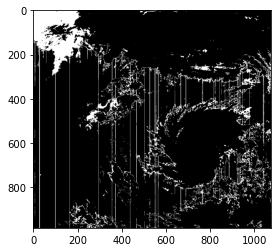

In [92]:
fig=plt.imshow(b2,cmap='gray')

In [94]:
b2=np.zeros((984,1074))

## Middle clouds

In [96]:
for i in range(len(b)):
    for j in range(len(b[0])):
        if(243<b[i][j]<273):
            b2[i][j]=255
        else:
            b2[i][j]=0

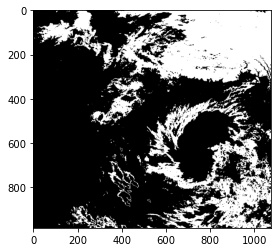

In [97]:
fig=plt.imshow(b2,cmap='gray')

## High cloud

In [100]:
b2=np.zeros((984,1074))

for i in range(len(b)):
    for j in range(len(b[0])):
        if(200<b[i][j]<243):
            b2[i][j]=255
        else:
            b2[i][j]=0

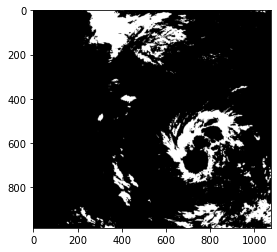

In [101]:
fig=plt.imshow(b2,cmap='gray')

## Cyclone

In [102]:
b2=np.zeros((984,1074))

for i in range(len(b)):
    for j in range(len(b[0])):
        if(b[i][j]<200):
            b2[i][j]=255
        else:
            b2[i][j]=0

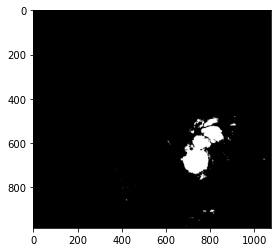

In [103]:
fig=plt.imshow(b2,cmap='gray')

## Classification

In [16]:
BR=pd.read_excel('TIR.xlsx')

def convert_temp(b):
    for i in range(len(b)):
        for j in range(len(b[0])):
            b[i][j]=BR[b[i][j]//1]


In [ ]:
def classify(b):
    c=0
    h=0
    l=0
    m=0
    b=c
    b=convert_temp(b)
    for i in range(len(b)):
        for j in range(len(b[0])):
            if(b[i][j]<200):
                c+=1
            if(200<b[i][j]<243):
                h+=1
            if(243<b[i][j]<270):
                m+=1
            else:
                l+=1
    mx=max(c,h,l,m)
    if(mx==c):
        return "Cyclone"
    elif(mx==h):
        return "High cloud"
    elif(mx==m):
        return "Medium height"
    else:
        return "Low cloud"

## Convert Data with GDAL and rasterio


The images downloaded from Mosdac did not follow the same coordinate system as those provided initially.

In [127]:
from affine import Affine
from pyproj import Proj, transform

In [128]:
dataset = rasterio.open('D:\\Downloads\\ISRO\\3DIMG_26MAY2020_0000_L1C_SGP_IMG_TIR1.tif')

In [129]:
 dataset.bounds

BoundingBox(left=-6122571.99363, bottom=-6413524.594094, right=6122571.99363, top=6413524.594094)

### The additinal images downloaded from ISRO cover a much larger area than the one given

In [131]:
from osgeo import osr, gdal

# get the existing coordinate system
ds = gdal.Open('D:\\Downloads\\ISRO\\3DIMG_26MAY2020_0000_L1C_SGP_IMG_TIR1.tif')
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
    GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs .ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs) 

#get the point to transform, pixel (0,0) in this case
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
print(minx,miny)
#get the coordinates in lat long
latlong = transform.TransformPoint(-1337128.0143214436, 557271.5692416131) 
print(latlong)

-6122571.99363 -6413524.594094
(62.9883746791066, 5.03322118158081, 0.0)


In [132]:
latlong

(62.9883746791066, 5.03322118158081, 0.0)

In [133]:
transform1 = osr.CoordinateTransformation(new_cs,old_cs) 
lg = transform1.TransformPoint(latlong[0],latlong[1]) 
lg

(-1337128.0143214436, 557271.5692415652, 0.0)

In [134]:
from osgeo import gdal
ds = gdal.Open('INSAT3D_TIR1_India\\3DIMG_07NOV2019_0000_L1C_SGP.tif')
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]
print(minx,miny,maxx,maxy)


62.9883746791066 5.033221181581247 99.00203646175873 38.02897834557538


In [135]:
ll=transform1.TransformPoint(minx,miny) 
lm=transform1.TransformPoint(maxx,maxy) 

In [136]:
ll,lm

((-1337128.0143214436, 557271.5692416131, 0.0),
 (2671894.4769245693, 4557193.653118913, 0.0))

In [138]:
from osgeo import gdal

raster_file = "D:\\Downloads\\ISRO\\3DIMG_26MAY2020_0000_L1C_SGP_IMG_TIR1.tif"
ds = gdal.Open(raster_file)

# GetGeoTransform gives the (x, y) origin of the top left pixel,
# the x and y resolution of the pixels, and the rotation of the
# raster. If the raster is rotated (i.e. the rotation values are
# anything other than 0) this method will not work.

# The information is returned as tuple:
# (TL x, X resolution, X rotation, TL y, Y rotation, y resolution)
TL_x, x_res, _, TL_y, _, y_res = ds.GetGeoTransform()

# The point where you wish to sample the raster
(x,y) = (2671894.4769245693, 4557193.653118913)

# Divide the difference between the x value of the point and origin,
# and divide this by the resolution to get the raster index
x_index = (x - TL_x) // x_res

# and the same as the y
y_index = (y - TL_y) // y_res

# Read the raster as an array
array = ds.ReadAsArray()

# Sample with the indexs, not that y_index should be first as the index is
# [rows, columns] in a 2d grid in python
y_index=round(y_index)
x_index=round(x_index)
print(y_index,x_index)
pixel_val = array[y_index, x_index]

464 2199


### Therefore, columns 1196 to 2199 and rows 464 to 1464 of the new dataset represent the area of interest in newly downloaded images. Since the original dataset was of dimensions 984 * 1074, we reduce some rows and increase some columns

In [148]:
import h5py
filename = "D:\\Downloads\\ISRO\\3DSND_07MAY2020_1200_L1B_SA1.h5"
app=[]
with h5py.File(filename, "r") as f:
    for i in f.keys():
        2+2


In [161]:
import h5py
filename = "D:\\Downloads\\ISRO\\3DIMG_07NOV2019_1200_L2B_CTP.h5"

with h5py.File(filename, "r") as f:
        print(f.keys())
        cr=list(f['CTP'])[0]
        co=list(f['CTT'])[0]

len(cr)

<KeysViewHDF5 ['CLRFR_MIR', 'CLRFR_TIR1', 'CLRFR_TIR2', 'CLRFR_WVR', 'CSBT_Latitude', 'CSBT_Longitude', 'CSBT_MIR', 'CSBT_TIR1', 'CSBT_TIR2', 'CSBT_WVR', 'CTP', 'CTT', 'EFF_EMISS', 'GeoX', 'GeoX_csbt', 'GeoY', 'GeoY_csbt', 'Latitude', 'Longitude', 'OFLG_MIR', 'OFLG_TIR1', 'OFLG_TIR2', 'OFLG_WVR', 'SAT_ZEN', 'SOL_ZEN', 'STDV_MIR', 'STDV_TIR1', 'STDV_TIR2', 'STDV_WVR', 'time']>


313

In [162]:
import h5py
filename = "D:\\Downloads\\ISRO\\3DIMG_07NOV2019_1200_L2B_CTP.h5"

with h5py.File(filename, "r") as f:
        print(f.keys())
        CT=list(f['CTT'])[0]
        P=list(f['CTT'])[0]
        BT=list(f['CSBT_TIR1'])[0]
        l=list(f['Latitude'])
        



<KeysViewHDF5 ['CLRFR_MIR', 'CLRFR_TIR1', 'CLRFR_TIR2', 'CLRFR_WVR', 'CSBT_Latitude', 'CSBT_Longitude', 'CSBT_MIR', 'CSBT_TIR1', 'CSBT_TIR2', 'CSBT_WVR', 'CTP', 'CTT', 'EFF_EMISS', 'GeoX', 'GeoX_csbt', 'GeoY', 'GeoY_csbt', 'Latitude', 'Longitude', 'OFLG_MIR', 'OFLG_TIR1', 'OFLG_TIR2', 'OFLG_WVR', 'SAT_ZEN', 'SOL_ZEN', 'STDV_MIR', 'STDV_TIR1', 'STDV_TIR2', 'STDV_WVR', 'time']>


In [155]:
import h5py
filename = "D:\\Downloads\\ISRO\\3DIMG_08JUN2020_0700_L1C_SGP.h5"

with h5py.File(filename, "r") as f:
        print(f.keys())
        ir=list(f['IMG_TIR1'])[0]
        vs=list(f['IMG_VIS'])[0]
        val=list(f['IMG_VIS_ALBEDO'])

<KeysViewHDF5 ['GreyCount', 'IMG_MIR', 'IMG_MIR_RADIANCE', 'IMG_MIR_TEMP', 'IMG_SWIR', 'IMG_SWIR_RADIANCE', 'IMG_TIR1', 'IMG_TIR1_RADIANCE', 'IMG_TIR1_TEMP', 'IMG_TIR2', 'IMG_TIR2_RADIANCE', 'IMG_TIR2_TEMP', 'IMG_VIS', 'IMG_VIS_ALBEDO', 'IMG_VIS_RADIANCE', 'IMG_WV', 'IMG_WV_RADIANCE', 'IMG_WV_TEMP', 'Projection_Information', 'Sat_Azimuth', 'Sat_Elevation', 'Sun_Azimuth', 'Sun_Elevation', 'X', 'Y', 'proj_dim', 'time']>


In [156]:
b2=[]
for i in ir[472:1456]:
    b2.append(i[1161:2235])

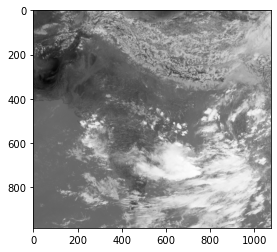

In [157]:
fig=plt.imshow(b2,cmap='gray')

In [158]:
b2=[]

for i in vs[472:1456]:
    b2.append(i[1161:2235])

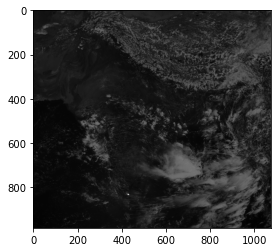

In [159]:
fig=plt.imshow(b2,cmap='gray')